In [25]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 512
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1)

with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

12.736577 M parameters


In [28]:
max_iters = 2000
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % (max_iters / 10) == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.4070, val loss 1.6181
step 200: train loss 1.3886, val loss 1.6038
step 400: train loss 1.3647, val loss 1.5967
step 600: train loss 1.3514, val loss 1.5819
step 800: train loss 1.3383, val loss 1.5684
step 1000: train loss 1.3262, val loss 1.5801
step 1200: train loss 1.3093, val loss 1.5610
step 1400: train loss 1.2931, val loss 1.5623
step 1600: train loss 1.2847, val loss 1.5710
step 1800: train loss 1.2769, val loss 1.5526
step 1999: train loss 1.2641, val loss 1.5551


In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/clark/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/clark/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


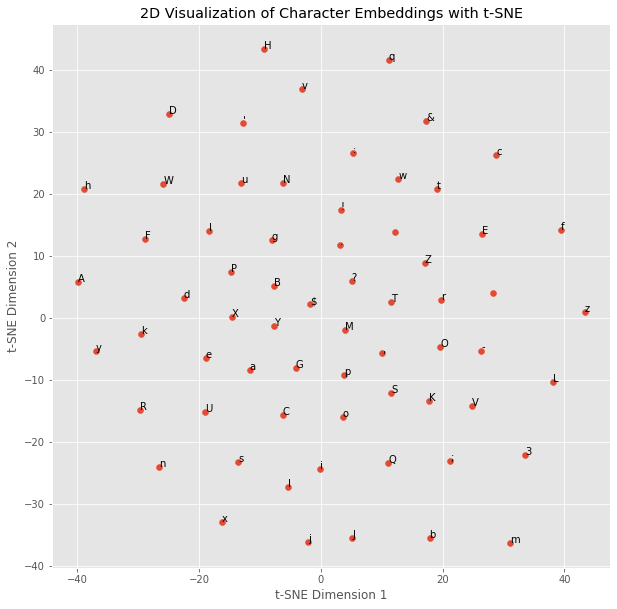

In [33]:
from sklearn.manifold import TSNE

def plot_embeddings_with_tsne(model, itos):
    embeddings = model.token_embedding_table.weight.data.cpu().numpy()
    
    # Use t-SNE to reduce the embeddings' dimensionality
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    
    for i, char in enumerate(itos.values()):
        plt.annotate(char, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("2D Visualization of Character Embeddings with t-SNE")
    plt.grid(True)
    plt.show()

plot_embeddings_with_tsne(model, itos)


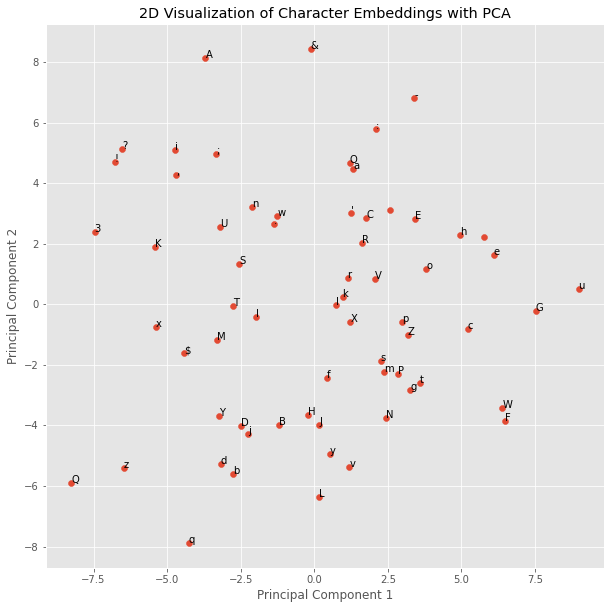

In [30]:
from sklearn.decomposition import PCA

def plot_embeddings_with_pca(model, itos):
    # Extract the token embeddings from the model
    embeddings = model.token_embedding_table.weight.data.cpu().numpy()

    # Use PCA to reduce the embeddings' dimensionality
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

    # Annotate the points with their corresponding characters
    for i, char in enumerate(itos.values()):
        plt.annotate(char, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D Visualization of Character Embeddings with PCA")
    plt.grid(True)
    plt.show()

# Call the function to plot the embeddings
plot_embeddings_with_pca(model, itos)

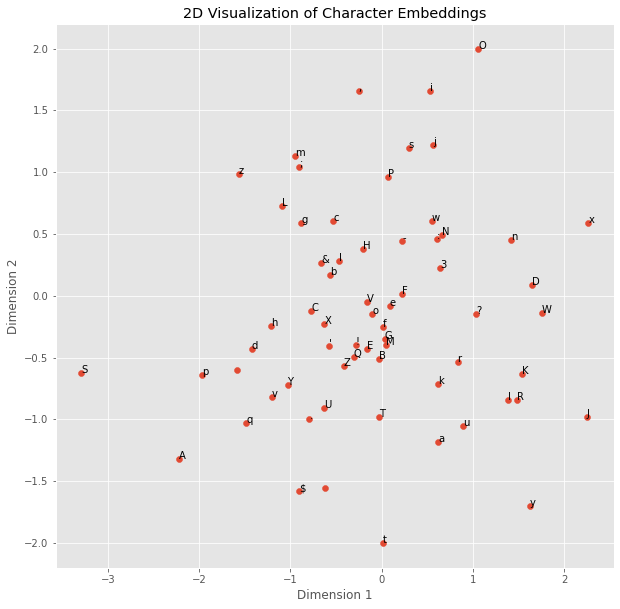

In [13]:
def plot_embeddings(model, itos):
    # Extract the token embeddings from the model
    embeddings = model.token_embedding_table.weight.data.cpu().numpy()

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])

    # Annotate the points with their corresponding characters
    for i, char in enumerate(itos.values()):
        plt.annotate(char, (embeddings[i, 0], embeddings[i, 1]))

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("2D Visualization of Character Embeddings")
    plt.grid(True)
    plt.show()

# Call the function to plot the embeddings
plot_embeddings(model, itos)

In [ ]:
import numpy as np

# Assuming vocab is a list of your words such that vocab[i] returns the word for index i
# If you don't have this list, you might need to create it based on how you've setup your data.

def plot_embeddings(model, vocab, sample_words=None):
    # 1. Extract embeddings
    embeddings = model.token_embedding_table.weight.data.cpu().numpy()
    
    # 2. Plot embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)

    # 3. Annotate some points
    if sample_words:
        for word in sample_words:
            idx = vocab.index(word)
            plt.annotate(word, (embeddings[idx, 0], embeddings[idx, 1]), fontsize=9, alpha=0.75)
    else:
        for idx, word in enumerate(vocab):
            plt.annotate(word, (embeddings[idx, 0], embeddings[idx, 1]), fontsize=9, alpha=0.75)

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Token Embeddings Visualization')
    plt.grid(True)
    plt.show()

# Get a batch for demonstration
# _, _, vocab = get_batch(...) # modify as per your get_batch function if it provides vocab

# Sample words you specifically want to annotate (optional)
# If your vocab is large, annotating all points will make the plot cluttered.
sample_words = ['example', 'word1', 'word2']  # replace with words from your vocab

plot_embeddings(model, vocab, sample_words=sample_words)

In [8]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


BOFemlane, liver, his lomy ayd fthysein,
Arond Gramf not meflall youre, Ame that of blathe conntlourd is to kie wellt Ond clecolove
Tust to neman thas re of hall, imis if hicer
Tone heinCs as your that his cone be mandierluth that: hime,
Lold of cherent dumpwest anden, lammn unest sombleeass
for and driey me whith lon mapporuoone.

DUODY IUSCll slime, knom, your my shey, grand. he dous'se ress pan.

Ol but elaing shour Buovence aft thim woordeaind youy:
Jroh he knolld fnour
Ast Edyour I crand limfinel, lible,
Abrat Ast fuay st, lictheime ighard inglow,
Wat do hath driess de, nomn ane wind set!

Dow'd I whay to thot deirs my harme or murd.

MerryNIUS yeeslent:
What obladty me weare sgoon, loik? mancuose to no, with,
Thou de yourr in knows with arm fome thill it it shis bousploody
That to mupongh son heracleg, yere a knould aph bust tish gun in Donowere: to nellave no. Yoouy cordsand, hastlior?

Cereht that hill him be cringen?

Bekty his by to Richseredt, respere'fires.

Sreay wonl is 